<a href="https://www.kaggle.com/code/lukalafaye/gan-mnist-dslab2?scriptVersionId=206783585" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SAN

In [1]:
!pip3 install torch torchview tqdm matplotlib pytorch-fid

# Generator

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from torch.nn.utils import spectral_norm

class Generator(nn.Module):
    def __init__(self, g_output_dim=784, dim_latent=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Discriminator

In [49]:
class BaseDiscriminator(nn.Module):
    def __init__(self, d_input_dim=784):
        super(BaseDiscriminator, self).__init__()
        self.h_function = nn.Sequential(
            #nn.Linear(d_input_dim, 512),
            spectral_norm(nn.Linear(d_input_dim, 1024)),
            nn.LeakyReLU(0.2),
            #nn.Linear(1024, 512),
            #nn.LeakyReLU(0.2),
            #nn.Linear(512, 256),
            spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2),
            #nn.Linear(256, 1)
            spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
        )

        self.fc_w = nn.Parameter(torch.randn(1, 256))

    def forward(self, x, flg_train: bool):        
        h_feature = self.h_function(x)
        weights = self.fc_w
        out = (h_feature * weights).sum(dim=1)
        return out

class SanDiscriminator(BaseDiscriminator):
    def __init__(self, d_input_dim=784):
        super(SanDiscriminator, self).__init__(d_input_dim)

    def forward(self, x, flg_train: bool):
        h_feature = self.h_function(x)        
        weights = self.fc_w
        direction = F.normalize(weights, dim=1)  # Normalize the last layer
        scale = torch.norm(weights, dim=1).unsqueeze(1)
        h_feature = h_feature * scale  # Keep the scale
        if flg_train:  # For discriminator training
            out_fun = (h_feature * direction.detach()).sum(dim=1)
            out_dir = (h_feature.detach() * direction).sum(dim=1)
            out = dict(fun=out_fun, dir=out_dir)
        else:  # For generator training or inference
            out = (h_feature * direction).sum(dim=1)
        return out


In [51]:
import torch
from torchview import draw_graph

# Define input dimensions and model
d_input_dim = 784
sample_model = SanDiscriminator(d_input_dim=d_input_dim)

# Create a dummy input tensor with the appropriate input dimensions
dummy_input = torch.randn(1, d_input_dim)

# Generate the computational graph
# Set `flg_train` as `True` for training visualization or `False` for inference visualization
graph = draw_graph(sample_model, input_data=[dummy_input, True], expand_nested=True)

graph.visual_graph
graph.visual_graph.format = "png"
graph.visual_graph.render("SanDiscriminator_Architecture")

'SanDiscriminator_Architecture.png'

In [52]:
import argparse
import json
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tqdm

from torch.utils.data import DataLoader


In [53]:
import os
import json

# Define folder paths
mnist_folder = './data/MNIST'
logs_folder = './logs'
params_path = './hparams/params.json'

# Create folders if they don't exist
os.makedirs(mnist_folder, exist_ok=True)
os.makedirs(logs_folder, exist_ok=True)
os.makedirs(os.path.dirname(params_path), exist_ok=True)

# Define the parameters for params.json
params = {
    "dim_latent": 100,
    "batch_size": 128,
    "learning_rate_d": 0.0001,
    "learning_rate_g": 0.0007,    
    "beta_1": 0.5,
    "beta_2": 0.999,
    "num_epochs": 150
}

# Write parameters to params.json
with open(params_path, 'w') as f:
    json.dump(params, f, indent=4)

print(f"Created folders '{mnist_folder}' and '{logs_folder}', and saved parameters to '{params_path}'.")


Created folders './data/MNIST' and './logs', and saved parameters to './hparams/params.json'.


In [54]:
default_args = {
    "datadir": "./data/MNIST",
    "params": "./hparams/params.json",
    "model": "san",
    "enable_class": False,
    "logdir": "./logs",
    "device": 0
}

In [55]:
from argparse import Namespace
args = Namespace(**default_args)

print(args.datadir)        # Access './data/MNIST'
print(args.params)         # Access './hparams/params.json'
print(args.model)          # Access 'gan'
print(args.enable_class)   # Access False
print(args.logdir)         # Access './logs'
print(args.device)         # Access 0

./data/MNIST
./hparams/params.json
san
False
./logs
0


In [56]:
# Train functions

def update_discriminator(x, discriminator, generator, optimizer, params):
    bs = x.size(0)
    device = x.device

    optimizer.zero_grad()

    # for data (ground-truth) distribution
    disc_real = discriminator(x, flg_train=True)
    loss_real = eval('compute_loss_'+args.model)(disc_real, loss_type='real')

    # for generator distribution
    latent = torch.randn(bs, params["dim_latent"], device=device)
    img_fake = generator(latent)
    disc_fake = discriminator(img_fake.detach(), flg_train=True)
    loss_fake = eval('compute_loss_'+args.model)(disc_fake, loss_type='fake')


    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer.step()
    
    return loss_real, loss_fake

def update_generator(discriminator, generator, optimizer, params, device):
    optimizer.zero_grad()

    bs = params['batch_size']
    latent = torch.randn(bs, params["dim_latent"], device=device)

    batch_fake = generator(latent)

    disc_gen = discriminator(batch_fake, flg_train=False)
    loss_g = - disc_gen.mean()
    loss_g.backward()
    optimizer.step()

    if torch.isnan(loss_g).any():
        print("NaN detected in generator loss!")
        return loss_g
    return loss_g
    

def compute_loss_gan(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss = (1. - disc).relu().mean() # Hinge loss
    else: # 'fake' == loss_type
        loss = (1. + disc).relu().mean() # Hinge loss

    return loss


def compute_loss_san(disc, loss_type):
    assert (loss_type in ['real', 'fake'])
    if 'real' == loss_type:
        loss_fun = (1. - disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = - disc['dir'].mean() # Wasserstein loss for omega
    else: # 'fake' == loss_type
        loss_fun = (1. + disc['fun']).relu().mean() # Hinge loss for function h
        loss_dir = disc['dir'].mean() # Wasserstein loss for omega

    lambd = 5
    loss = loss_fun + lambd * loss_dir

    return loss


def save_images(imgs, idx, dirname='test'):
    # Ensure imgs is a numpy array if it's a tensor
    if isinstance(imgs, torch.Tensor):
        imgs = imgs.cpu().data.numpy()

    # If the images are grayscale (1 channel), repeat them to make them RGB (3 channels)
    if imgs.shape[1] == 1:  # This checks if there is only 1 channel (grayscale)
        imgs = np.repeat(imgs, 3, axis=1)  # Repeat the grayscale channel 3 times to make RGB

    # Create the output directory if it doesn't exist
    if not os.path.exists(f'out/{dirname}/'):
        os.makedirs(f'out/{dirname}/')

    # Set up the plot
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.05, hspace=0.05)

    # Loop through the batch of images
    for i, sample in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        # Ensure each sample has the shape (height, width, channels) for imshow
        sample = sample.transpose((1, 2, 0))  # Convert from (C, H, W) -> (H, W, C)

        # Plot the image
        plt.imshow(sample)

    # Save the plot to the directory
    plt.savefig(f'out/{dirname}/{str(idx).zfill(3)}.png', bbox_inches="tight")
    plt.close(fig)

def plot_generated_images(generator, epoch, num_images=20):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        # Create two rows of 10 images
        fig, axes = plt.subplots(2, 10, figsize=(15, 6))
        axes = axes.flatten()  # Flatten the axes array for easy iteration
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

def plot_losses(G_losses, D_real_losses, D_fake_losses):
    G_losses = [loss.detach().cpu().numpy() for loss in G_losses]
    D_real_losses = [loss.detach().cpu().numpy() for loss in D_real_losses]
    D_fake_losses = [loss.detach().cpu().numpy() for loss in D_fake_losses]
    
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_real_losses, label="Discriminator Real Loss")
    plt.plot(D_fake_losses, label="Discriminator Fake Loss")
    
    plt.title("Generator and Discriminator Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.ylim(-5, 5)
    plt.legend()
    plt.show()

san
hyperparameters: 
	dim_latent: 100
	batch_size: 128
	learning_rate_d: 0.0001
	learning_rate_g: 0.0007
	beta_1: 0.5
	beta_2: 0.999
	num_epochs: 150


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 1/150


100%|██████████| 469/469 [00:10<00:00, 43.35it/s]


D-real: tensor(-2.0064, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(1.5789, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.8248, device='cuda:0', grad_fn=<DivBackward0>)


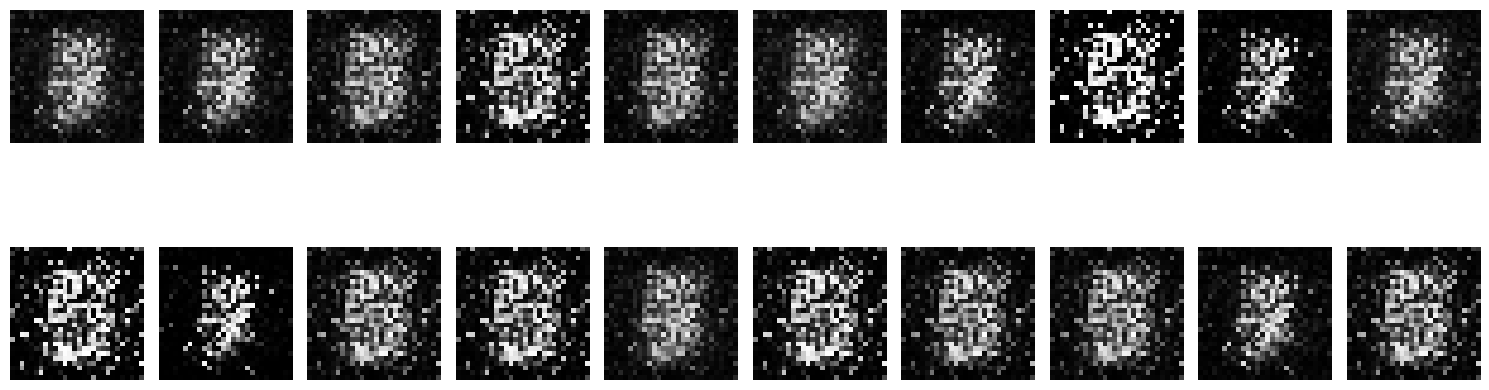

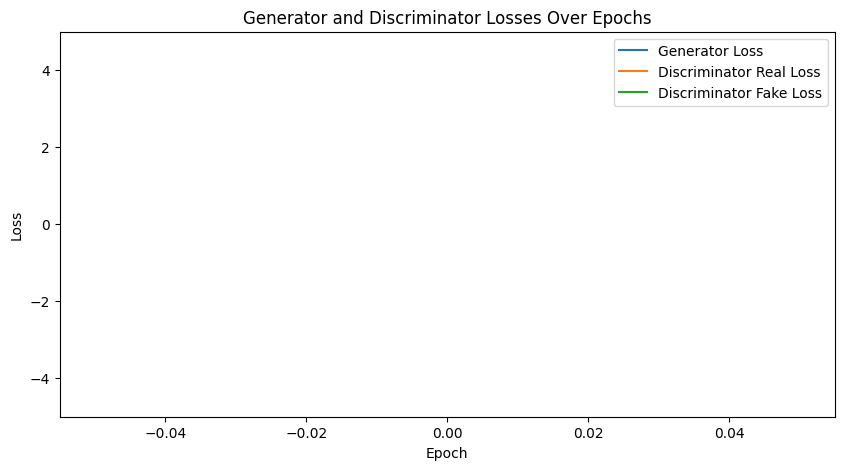

epoch: 2/150


100%|██████████| 469/469 [00:10<00:00, 45.78it/s]


D-real: tensor(-2.8433, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-2.3506, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(1.2682, device='cuda:0', grad_fn=<DivBackward0>)


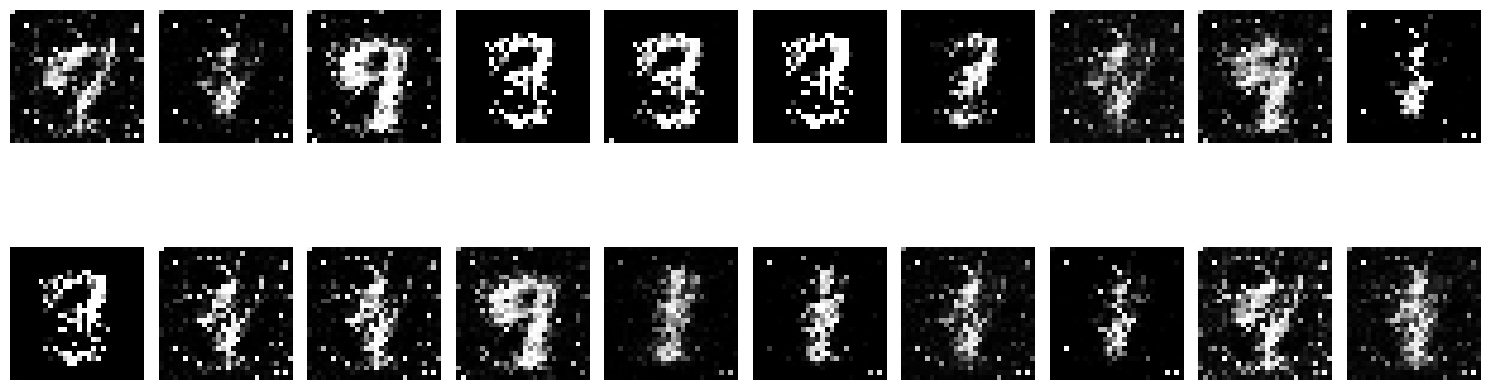

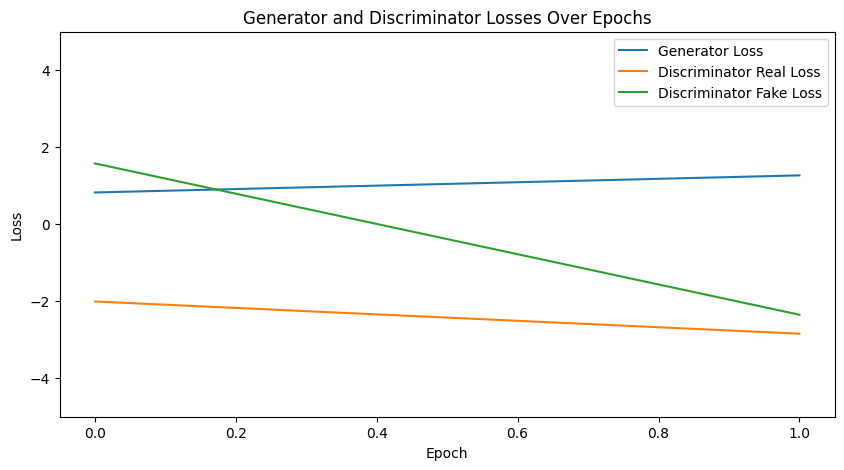

epoch: 3/150


100%|██████████| 469/469 [00:10<00:00, 43.62it/s]


D-real: tensor(-2.2294, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-2.4489, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(1.1658, device='cuda:0', grad_fn=<DivBackward0>)


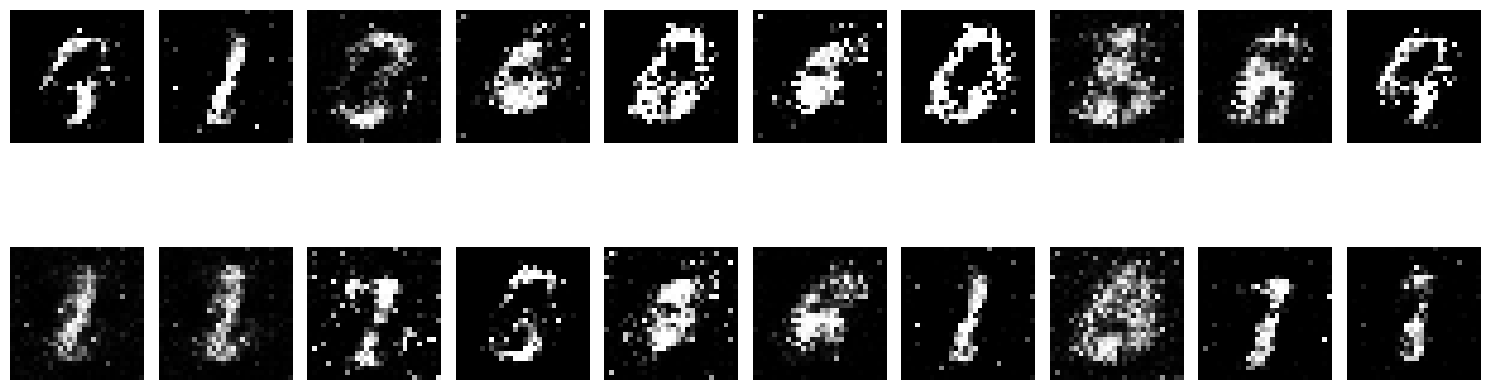

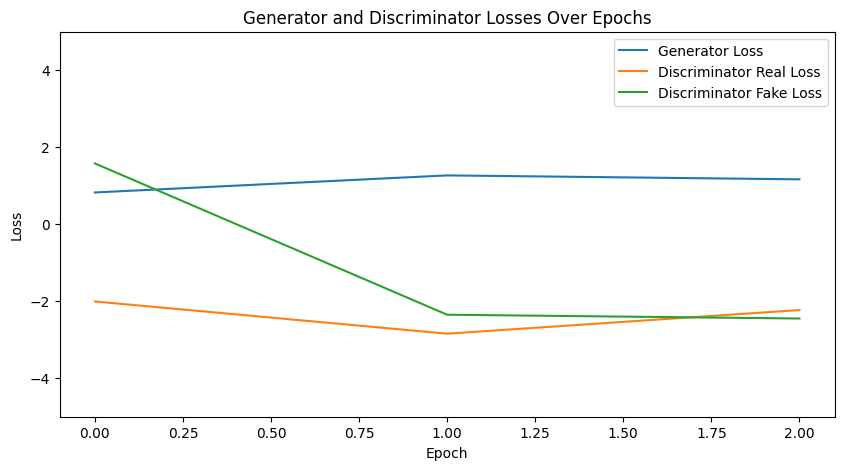

epoch: 4/150


100%|██████████| 469/469 [00:10<00:00, 46.09it/s]


D-real: tensor(-1.4114, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-1.9217, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.9196, device='cuda:0', grad_fn=<DivBackward0>)


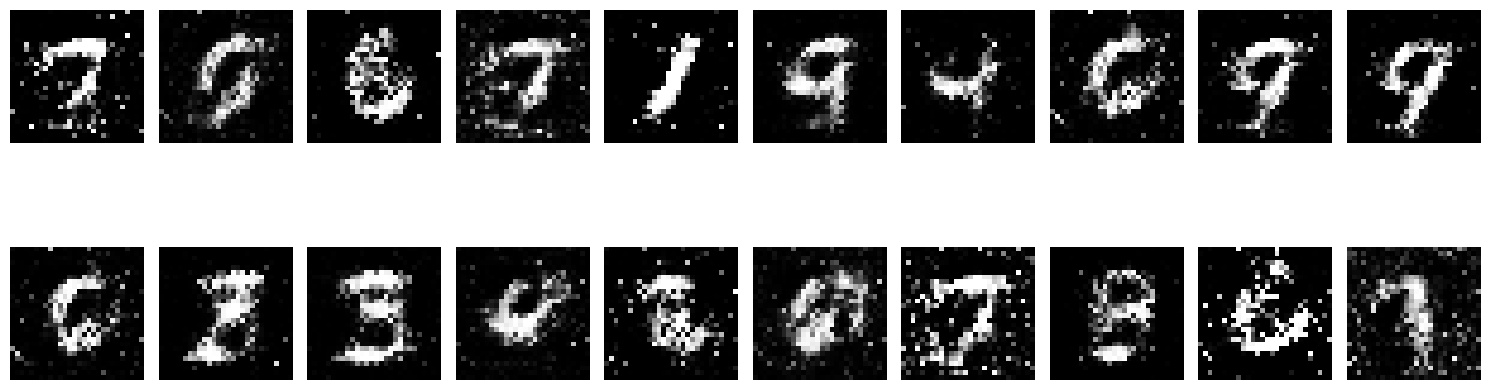

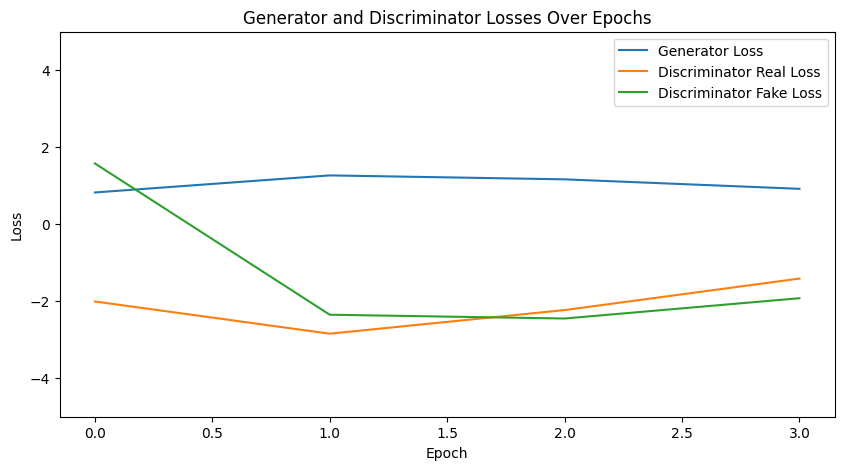

epoch: 5/150


100%|██████████| 469/469 [00:10<00:00, 43.81it/s]


D-real: tensor(-0.8340, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-1.5805, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.7478, device='cuda:0', grad_fn=<DivBackward0>)


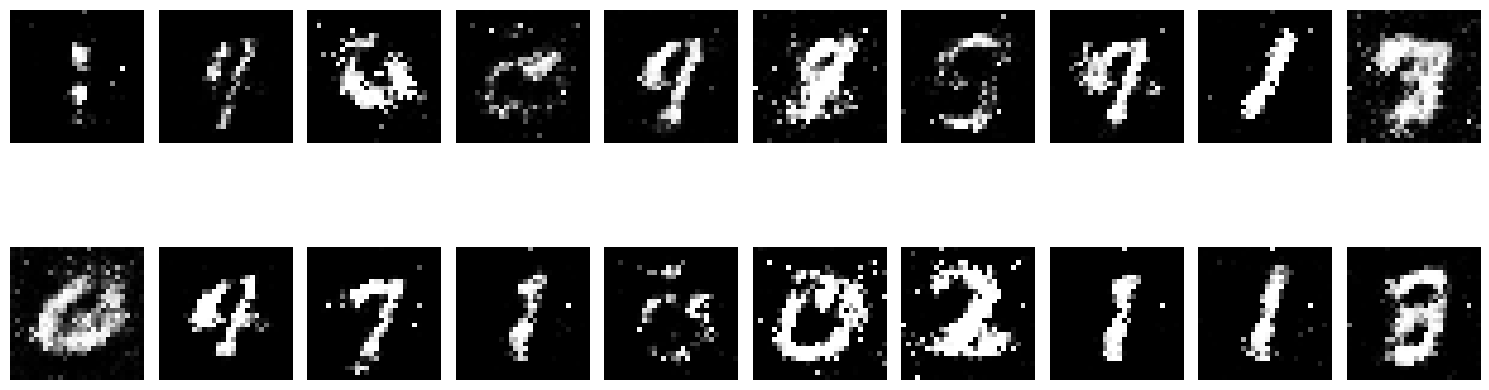

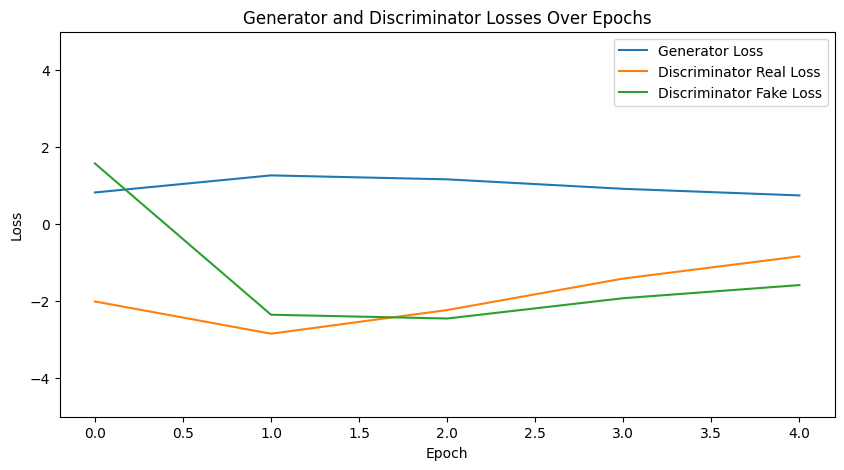

epoch: 6/150


100%|██████████| 469/469 [00:10<00:00, 45.67it/s]


D-real: tensor(-0.4519, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-1.1490, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.6313, device='cuda:0', grad_fn=<DivBackward0>)


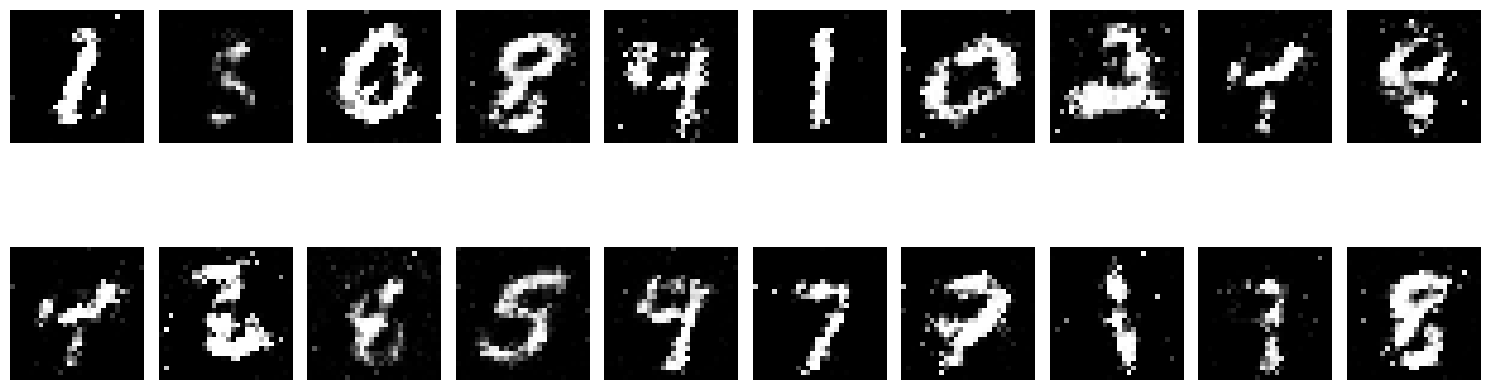

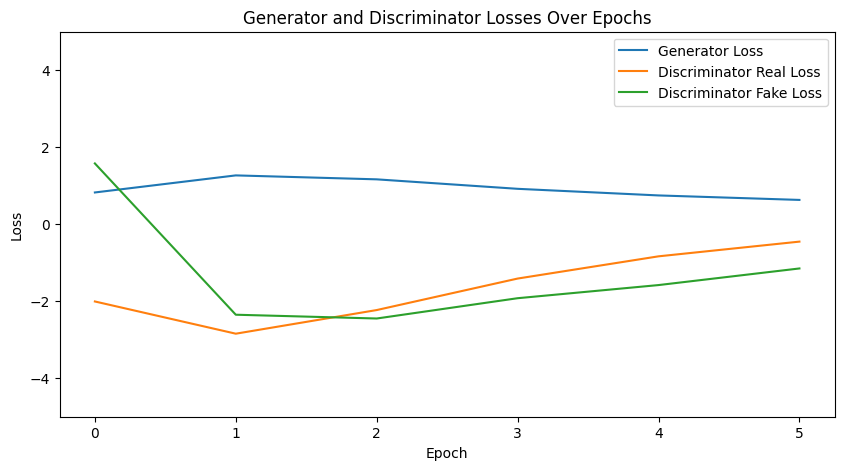

epoch: 7/150


100%|██████████| 469/469 [00:10<00:00, 44.13it/s]


D-real: tensor(-0.1615, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.8208, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.5578, device='cuda:0', grad_fn=<DivBackward0>)


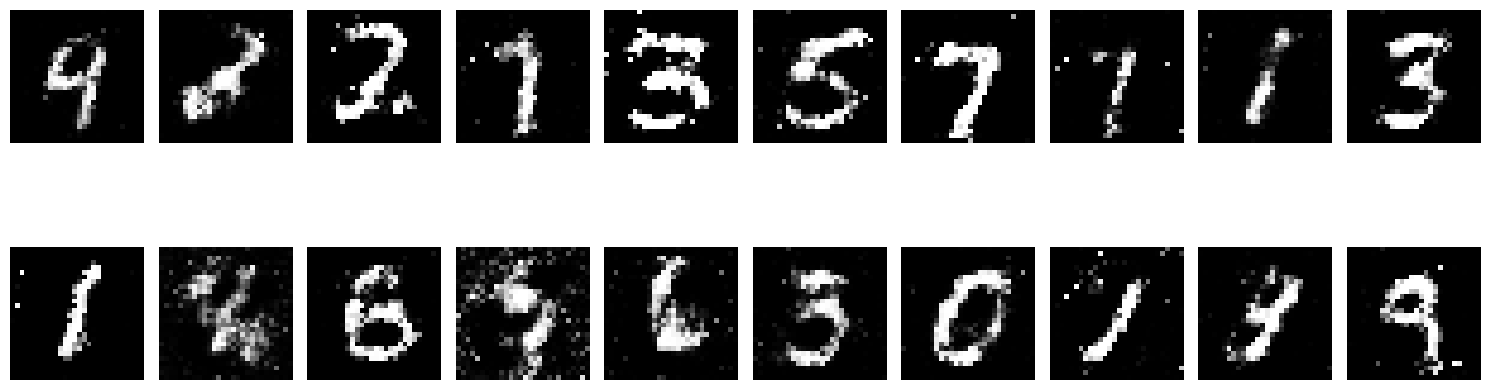

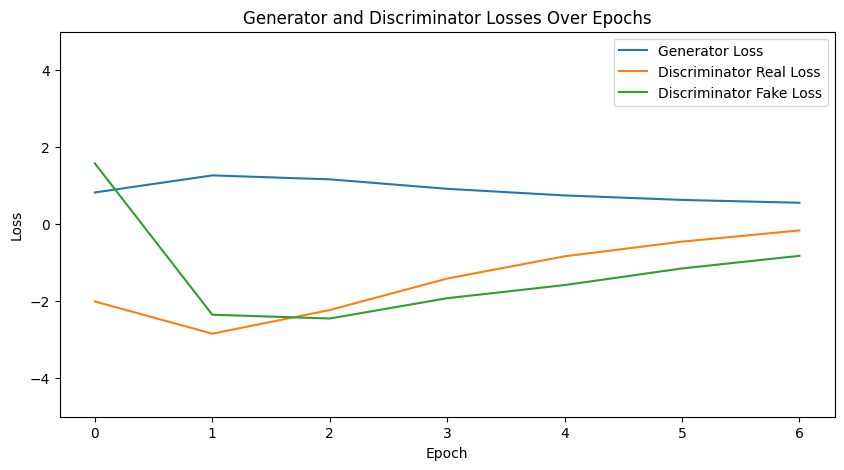

epoch: 8/150


100%|██████████| 469/469 [00:10<00:00, 45.55it/s]


D-real: tensor(0.0360, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.4951, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.4884, device='cuda:0', grad_fn=<DivBackward0>)


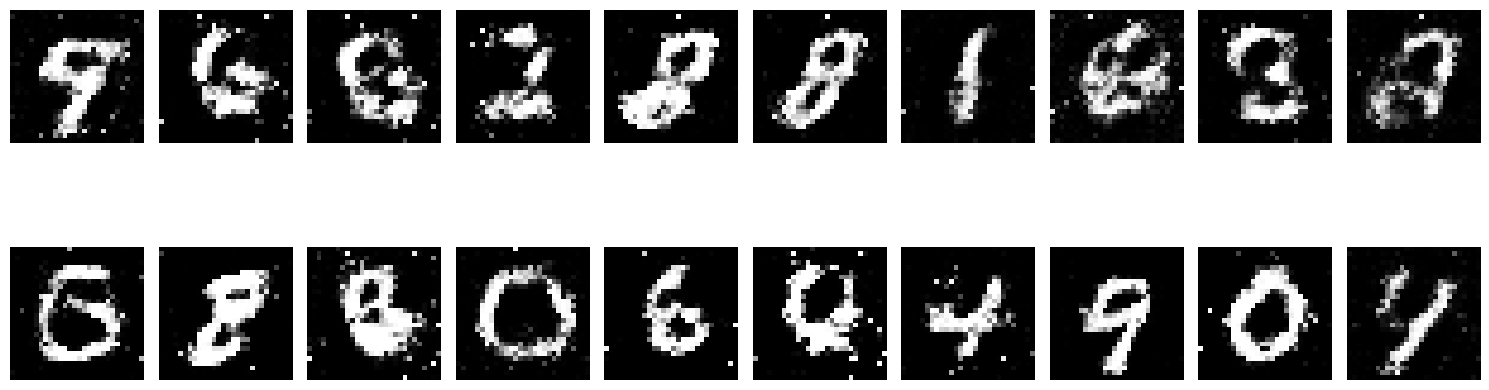

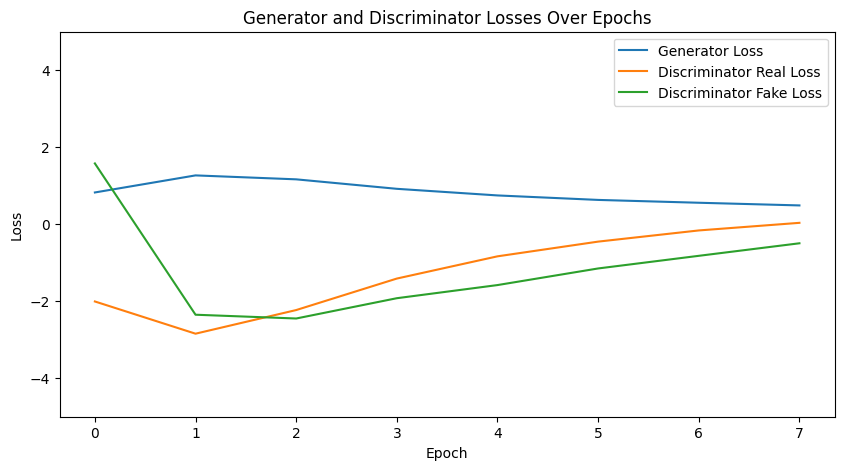

epoch: 9/150


100%|██████████| 469/469 [00:10<00:00, 43.36it/s]


D-real: tensor(0.0737, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.3437, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.4519, device='cuda:0', grad_fn=<DivBackward0>)


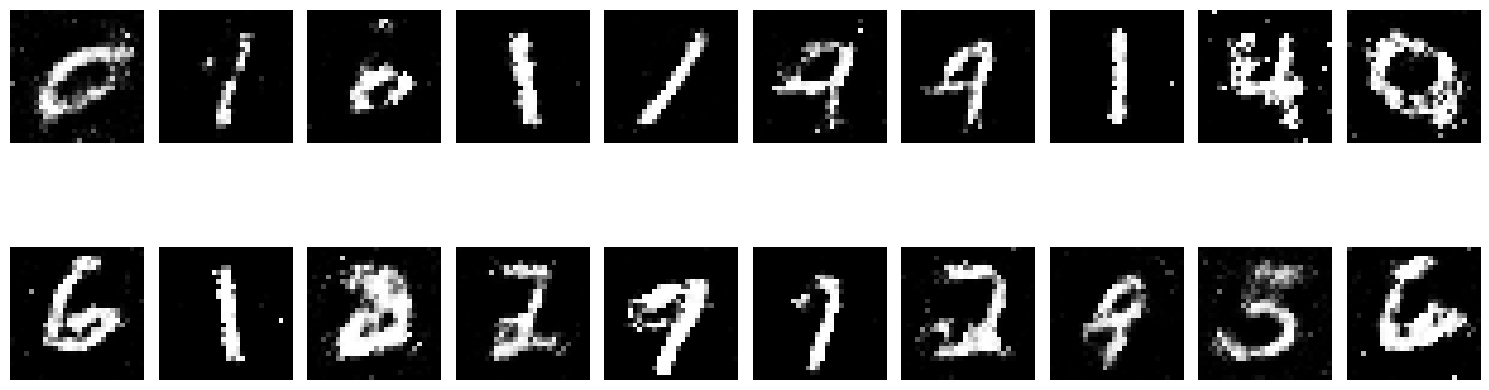

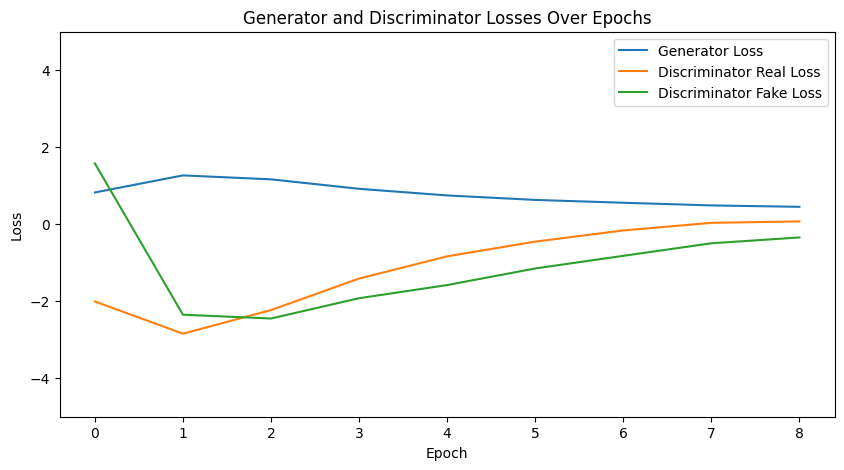

epoch: 10/150


100%|██████████| 469/469 [00:10<00:00, 45.34it/s]


D-real: tensor(0.1290, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.3150, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.4432, device='cuda:0', grad_fn=<DivBackward0>)


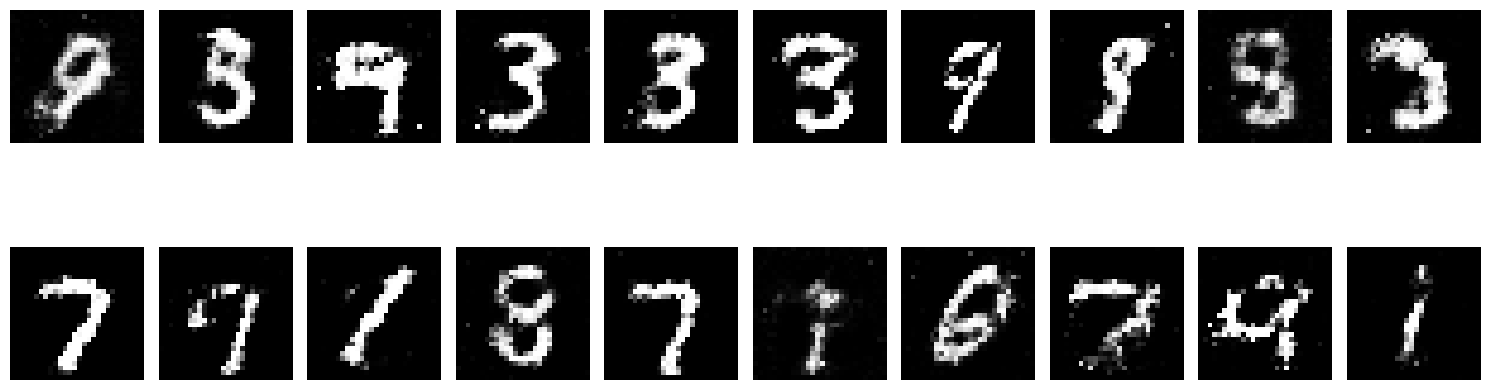

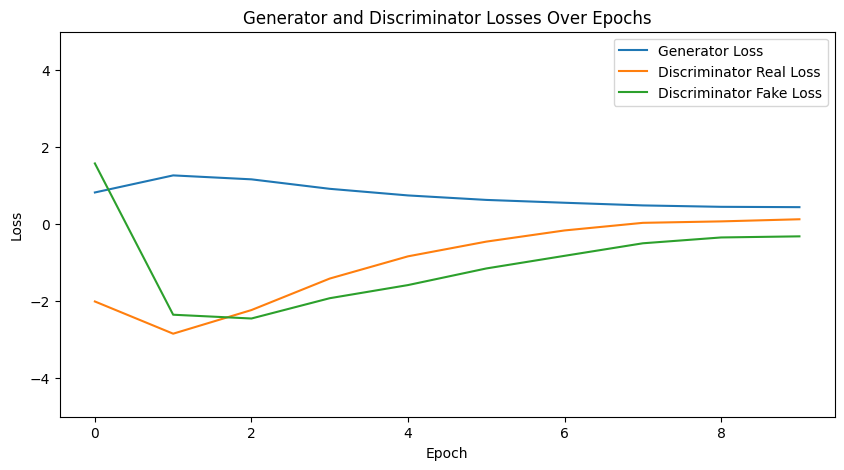

epoch: 11/150


100%|██████████| 469/469 [00:11<00:00, 41.80it/s]


D-real: tensor(0.1511, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.2358, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.4115, device='cuda:0', grad_fn=<DivBackward0>)


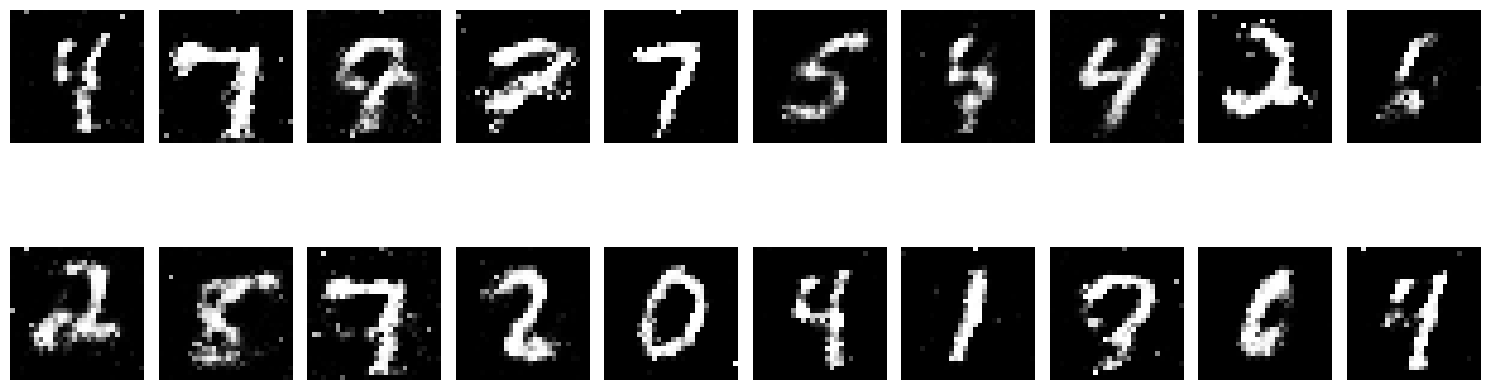

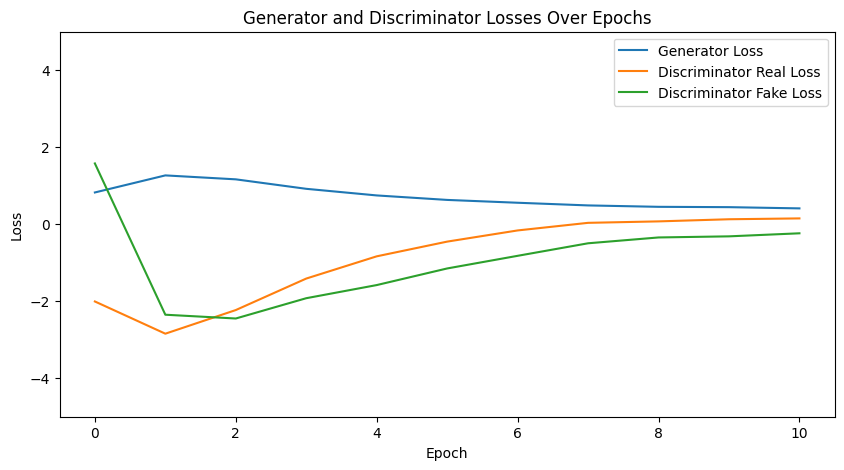

epoch: 12/150


100%|██████████| 469/469 [00:10<00:00, 43.50it/s]


D-real: tensor(0.1986, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.1684, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.4054, device='cuda:0', grad_fn=<DivBackward0>)


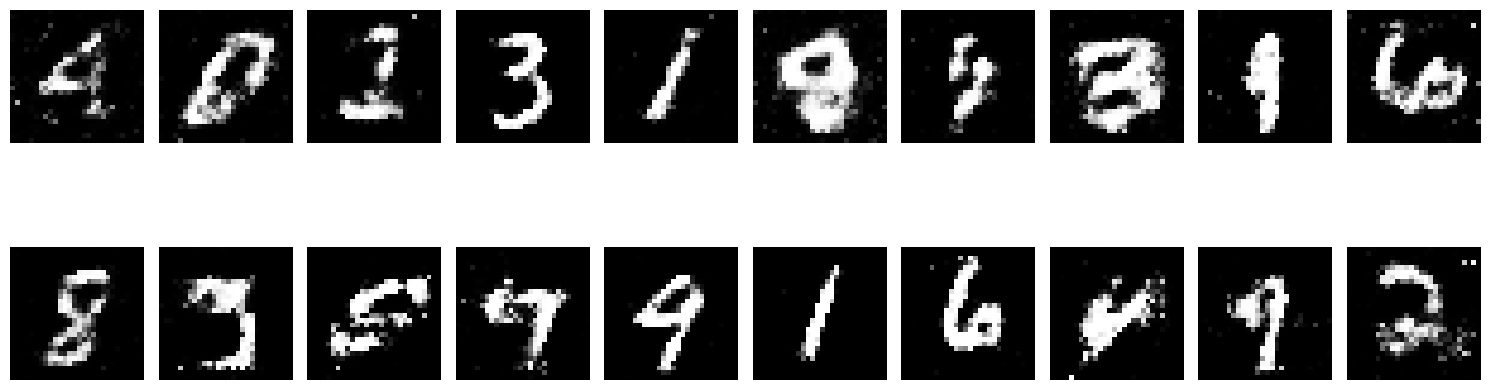

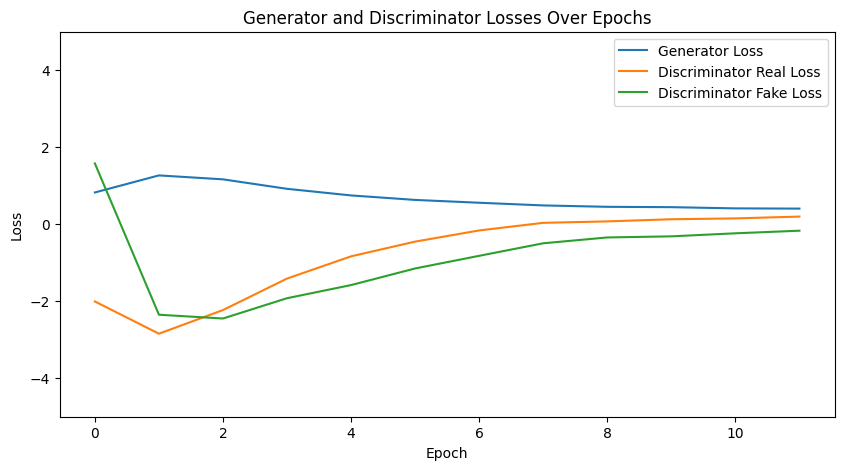

epoch: 13/150


100%|██████████| 469/469 [00:10<00:00, 43.87it/s]


D-real: tensor(0.2138, device='cuda:0', grad_fn=<DivBackward0>)
D-fake: tensor(-0.1223, device='cuda:0', grad_fn=<DivBackward0>)
G-fake: tensor(0.3953, device='cuda:0', grad_fn=<DivBackward0>)


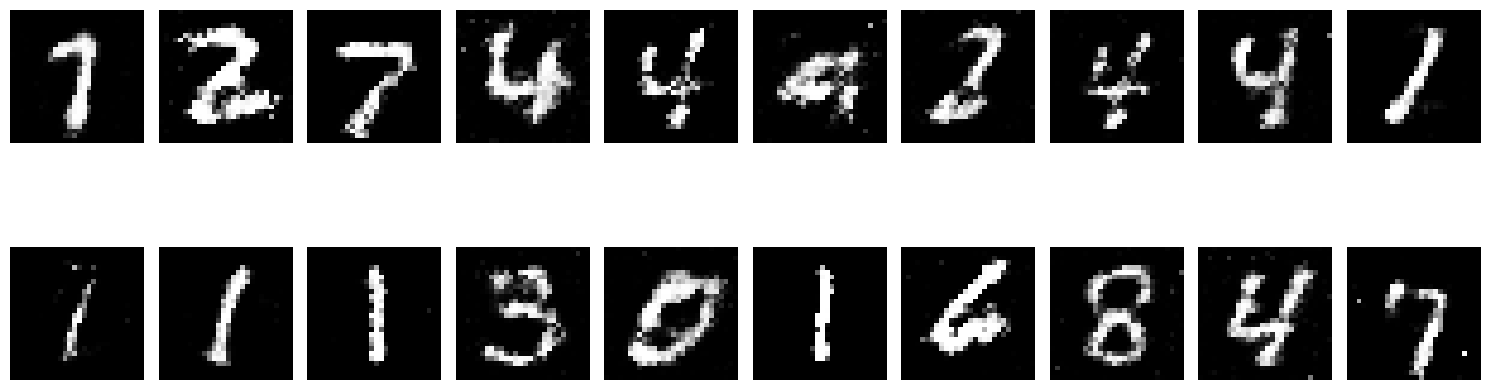

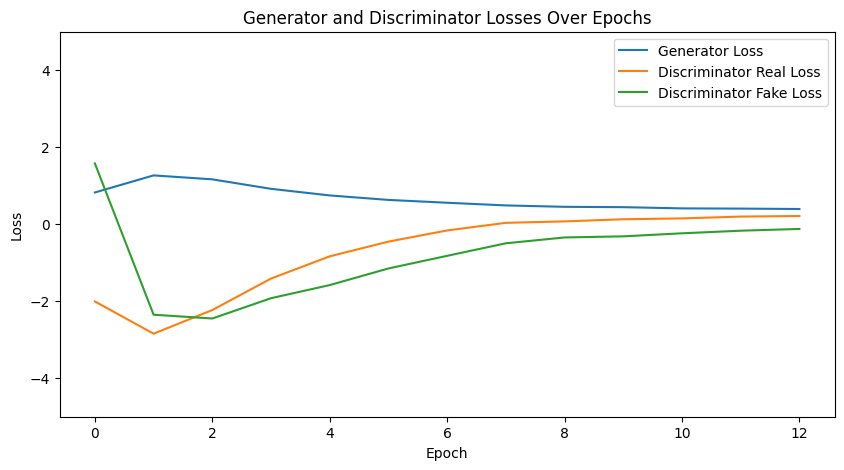

epoch: 14/150


 13%|█▎        | 61/469 [00:01<00:09, 45.18it/s]

In [ ]:
device = f'cuda:{args.device}' if args.device is not None else 'cpu'
model_name = args.model
print(model_name)
if not model_name in ['gan', 'san']:
    raise RuntimeError("A model name have to be 'gan' or 'san'.")
    
experiment_name = model_name + "_cond" if args.enable_class else model_name

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

# dataloading
num_class = 10
train_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], num_workers=8,
                          pin_memory=True, persistent_workers=True, shuffle=True)

test_dataset = datasets.MNIST(root=args.datadir, transform=transform, train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], num_workers=8,
                         pin_memory=True, persistent_workers=True, shuffle=False)

# model
generator = Generator(g_output_dim=784)

if 'gan' == args.model:
    discriminator = BaseDiscriminator(d_input_dim=784)
else: # 'san' == args.model
    discriminator = SanDiscriminator(d_input_dim=784)
generator = generator.to(device)
discriminator = discriminator.to(device)

# optimizer
betas = (params["beta_1"], params["beta_2"])
optimizer_G = optim.Adam(generator.parameters(), lr=params["learning_rate_g"], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=params["learning_rate_d"], betas=betas)

ckpt_dir = f'{args.logdir}/{experiment_name}/'
if not os.path.exists(args.logdir):
    os.mkdir(args.logdir)
if not os.path.exists(ckpt_dir):
    os.mkdir(ckpt_dir)

steps_per_epoch = len(train_loader)

msg = ["\t{0}: {1}".format(key, val) for key, val in params.items()]
print("hyperparameters: \n" + "\n".join(msg))

# eval initial states
num_samples_per_class = 10
with torch.no_grad():
    latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
    imgs_fake = generator(latent)


G_losses = []
D_real_losses = []
D_fake_losses = [] 

# main training loop
for n in range(params["num_epochs"]):
    loader = iter(train_loader)

    print("epoch: {0}/{1}".format(n + 1, params["num_epochs"]))
    G_loss_epoch = 0
    D_real_loss_epoch = 0
    D_fake_loss_epoch = 0

    for i in tqdm.trange(steps_per_epoch):
        x, class_ids = next(loader)
        x = x.to(device)
        x = x.view(x.size(0), -1)

        loss_real, loss_fake = update_discriminator(x, discriminator, generator, optimizer_D, params)
        G_loss = update_generator(discriminator, generator, optimizer_G, params, device)

        D_real_loss_epoch += loss_real
        D_fake_loss_epoch += loss_fake
        G_loss_epoch += G_loss


    # Store the average loss per epoch
    print("D-real:", D_real_loss_epoch / len(train_loader))
    print("D-fake:", D_fake_loss_epoch / len(train_loader))
    print("G-fake:", G_loss_epoch / len(train_loader))
    
    D_real_losses.append(D_real_loss_epoch / len(train_loader))
    D_fake_losses.append(D_fake_loss_epoch / len(train_loader))
    
    G_losses.append(G_loss_epoch / len(train_loader))
    

    plot_generated_images(generator, n+1)
    
    torch.save(generator.state_dict(), ckpt_dir + "g." + str(n) + ".tmp")
    torch.save(discriminator.state_dict(), ckpt_dir + "d." + str(n) + ".tmp")


    # eval
    with torch.no_grad():
        latent = torch.randn(num_samples_per_class * num_class, params["dim_latent"]).cuda()
        imgs_fake = generator(latent).cpu().data.numpy()
        imgs_fake = imgs_fake.reshape(-1, 1, 28, 28)
        save_images(imgs_fake, n, dirname=experiment_name)

    plot_losses(G_losses, D_real_losses, D_fake_losses)

torch.save(generator.state_dict(), ckpt_dir + "generator.pt")
torch.save(discriminator.state_dict(), ckpt_dir + "discriminator.pt")

## Generate more samples

In [ ]:
!rm -rf samples

In [ ]:
import torchvision

model = torch.nn.DataParallel(generator).cuda()
model.eval()

print('Model loaded.')


print('Start Generating')
os.makedirs('samples', exist_ok=True)

image_paths = []
batch_size = params["batch_size"]
dim_latent = params["dim_latent"]

n_samples = 0
with torch.no_grad():
    while n_samples<10000:
        z = torch.randn(batch_size, dim_latent).cuda()
        x = model(z)
        x = x.reshape(batch_size, 28, 28)
        for k in range(x.shape[0]):
            if n_samples<10000:
                image_path = os.path.join('samples', f'{n_samples}.png')
                torchvision.utils.save_image(x[k:k+1], image_path)         
                image_paths.append(image_path)  # Store image path
                n_samples += 1

In [ ]:
from IPython.display import display, Image

for img_path in image_paths[:10]:  # Slice to get only the first 10 images
    display(Image(filename=img_path))

In [ ]:
test_dataset

In [ ]:
# Directory to save images
mnist_image_dir = 'MNIST_images'
os.makedirs(mnist_image_dir, exist_ok=True)

# Define the inverse transform to unnormalize the images
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-1.0], std=[2.0])  # Undo the normalization (0.5 mean, 0.5 std)
])

# Save each image
for i, (image, _) in enumerate(test_dataset):
    # Inverse normalize and convert to PIL format
    image = inv_transform(image)
    image = transforms.ToPILImage()(image)
    
    # Save as PNG
    image.save(os.path.join(mnist_image_dir, f"image_{i}.png"))

In [ ]:
!ls -1 MNIST_images | wc -l

In [ ]:
!python -m pytorch_fid samples MNIST_images --device cuda:0